In [15]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### update_df(df)
Simple function which updates the loaded dataframe with three additional columns for further analysis these clumns are **'Q0/HaloMass'** (total halo luminosity of halo mass), **'R_v^3/HaloMass'** (virial radius to the third power divided by the halo mass) and **'StarMass'** (just the mass of the stars in the halo)

**Parameters**:
- **df**: Dataframe that needs to be updated

**Returns**:

In [2]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']
    return

### place_fesc(df)
Helper function that calculates the fraction of halos with an escape fraction below the threshold and sets these values to a small values above this threshold

**Parameters**:
- **fesc_arr**: Array of escape fractions
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)

**Returns**:
- **frac_small**: Fraction of halos with an escape fraction below **threshold**
- **fesc_arr**: Same as the input array with all values below **threshold** replaced by $f_\mathrm{esc} = 1.5 \cdot \mathrm{threshold}+\mathcal{U}(-0.5\cdot \mathrm{threshold},0.5\cdot \mathrm{threshold})$

In [3]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

### get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3)
Return means, error and variance of the escape fraction of each bin, the fraction of halos with small escape fraction for each bin as well as the centers of the bin for a dataframe

**Parameters**:
- **df**: Array of escape fractions
- **halo_prop**: Halo property along which to subdivide the dataframe can be either 'StarMass' or 'HaloMass' (default: 'StarMass')
- **bins**: Number of bins (default: 30)
- **mode**: How to calculate the average escape fraction 'mean' or 'median' (default: 'median')
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)



**Returns**:
- **x_values**: Masses (star or halo) of the individual halos
- **fesc**: f_esc of all halos
- **centers**: Centers of the logarithmically spaced bins
- **means**: Array of the average f_esc values
- **quantile16**: Values of the 16% quantile
- **quantile84**: Values of the 84% quantile
- **error**: Uncertainties in the average f_esc values
- **variance**: Variance in f_esc in a given bin
- **frac_small_arr**: Fraction of halos with f_esc below **threshold** in each bin 

In [4]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3, y_axis='f_esc'):
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    error = []
    centers = []
    variance = []
    frac_small_arr = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][y_axis]
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        frac_small_arr.append((sub_fesc < threshhold).sum()/len(sub_fesc))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84)
    error = np.array(error) 
    centers = np.array(centers)
    variance = np.array(variance)
    frac_small_arr = np.array(frac_small_arr)
        
    return centers, means, quantile16, quantile84, error, variance, frac_small_arr

### plot_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshold=1e-3, include_frac=False, save = False)
Plots scatter and average of the escape fraction for a dataframe as well as the variance in each bin and, if needed the fraction of halos in each bin with an escape fraction below threshold

**Parameters**:
- **df**: Array of escape fractions
- **halo_prop**: Halo property along which to subdivide the dataframe can be either 'StarMass' or 'HaloMass' (default: 'StarMass')
- **bins**: Number of bins (default: 30)
- **mode**: How to calculate the average escape fraction 'mean' or 'median' (default: 'median')
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)
- **include_frac**: If 'True' adds an additional plot with the fraction of halos in each bin below a certain threshold (default: False)
- **save**: If 'True' saves the plot to the 'plots' directory as '**halo_prop**_fesc.pdf' (default: False)




**Returns**:

In [5]:
def plot_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshold=1e-3, 
                 include_frac=False, save=False, lin=False, galaxy=False, include_galaxy=False):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 8
    quantile_alpha = 0.3
    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    size_label = 30
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 20
    fig_height = 25
    axes_width = 3
    tick_labelsize = 35

    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    if galaxy:
        y_axis = 'f_esc_0_2' 
        y_label = '$f_\mathrm{esc, gal}$'
        var_label = '$\mathrm{var}(f_\mathrm{esc, gal})$'
        low_esc_label = '$P(f_\mathrm{esc, gal}<10^{-3})$'
    else:
        y_axis = 'f_esc' 
        median_label = r'$\langle f_\mathrm{esc} \rangle $'
        median_gal_label = r'$\langle f_\mathrm{esc, gal} \rangle $'
        y_label = '$f_\mathrm{esc}$'
        var_label = '$\mathrm{var}(f_\mathrm{esc})$'
        low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    centers, means, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df, halo_prop=halo_prop, 
                                                                                          bins=bins, mode=mode, y_axis=y_axis)
    
    _, means_gal, *_ = get_scatter(df, halo_prop=halo_prop, bins=bins, mode=mode, y_axis='f_esc_0_2')

    f_esc = np.array(df[y_axis])
    frac_small, f_esc_plot = place_fesc(f_esc, threshold)
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    ax1 = plt.subplot2grid((4 ,1), (0,0), rowspan=2)
    for z in redshifts:
        sub_df = df[df.z==z]
        x_ax_val = np.array(sub_df[halo_prop])
        _, y_ax_val =  place_fesc(np.array(sub_df[y_axis]), threshold)
        ax1.scatter(np.log10(x_ax_val*mult), y_ax_val, label=f'z={z}', zorder=-15)
    x_bins = np.log10(centers*mult)
    ax1.plot(x_bins, means, linewidth=linewidth,  color='red', label=median_label)
    if include_galaxy:
        ax1.plot(x_bins, means_gal, linewidth=linewidth,  color='blue', linestyle='--', label=median_gal_label)
    ax1.fill_between(x_bins, quantile16, quantile84, color='red', alpha=quantile_alpha)
    #ax1.errorbar(np.log10(centers*mult), means, yerr=error, linewidth=4, elinewidth=2, capsize=10, color='red', label=r'$\langle f_\mathrm{esc} \rangle$')
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(threshold, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)
    ax1.set_rasterization_zorder(-15)
    
    ax2 = plt.subplot2grid((4,1), (2,0), sharex=ax1)
    ax2.plot(np.log10(centers*mult), variance, linewidth=linewidth)
    ax2.set_ylabel(var_label, size=size_label)
    ax2.set_xlabel(x_label, size=size_label)
    ax2.set_yscale('log')
    ax2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    
    if include_frac:
        ax3 = plt.subplot2grid((4,1), (3,0), sharex=ax2)
        ax3.plot(np.log10(centers*mult), frac_small_arr, linewidth=linewidth)
        ax3.set_ylabel(low_esc_label, size=size_label)
        ax3.set_xlabel(x_label, size=size_label)
        ax3.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax3.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')

    #xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    #plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_lin.pdf'
        else:
            if galaxy:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_galaxy.pdf'
            else:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [6]:
def plot_dust_comparison(comparison_df, halo_prop='StarMass', bins=30, mode='median', scatter=False,
                         save=False, lin=False, galaxy=False, residual=False, with_z=False):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 6
    markersize = 260
    markersize_scat = 60
    if residual:
        upper_y_threshold = 1e-2
        lower_y_threshold_lin = 0.
        lower_y_threshold_log = 1e-6
    else:
        upper_y_threshold = 1.
        lower_y_threshold_lin = 0.
        lower_y_threshold_log = 1e-3
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 35
    
    results = {}
    results['dust'] = {}
    results['dust']['x'] = {}
    results['dust']['y'] = {}
    
    results['no_dust'] = {}
    results['no_dust']['x'] = {}
    results['no_dust']['y'] = {}

    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    if residual:
        y_label = '$f_\mathrm{esc, no\_dust}-f_\mathrm{esc, dust}$'
    else: 
        y_label = '$f_\mathrm{esc}$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    if with_z:
        for z in redshifts: 
            centers_dust, means_dust, *_ = get_scatter(comparison_df[comparison_df.z==z], halo_prop=halo_prop, bins=bins, 
                                                       mode=mode, y_axis='f_esc_dust')
            centers_no_dust, means_no_dust, *_ = get_scatter(comparison_df[comparison_df.z==z], halo_prop=halo_prop, bins=bins, 
                                                             mode=mode, y_axis='f_esc_no_dust')

            results['dust']['x'][z] = centers_dust
            results['dust']['y'][z] = means_dust

            results['no_dust']['x'][z] = centers_no_dust
            results['no_dust']['y'][z] = means_no_dust
    else:
        centers_dust, means_dust, *_ = get_scatter(comparison_df, halo_prop=halo_prop, bins=bins, mode=mode, y_axis='f_esc_dust')
        centers_no_dust, means_no_dust, *_ = get_scatter(comparison_df, halo_prop=halo_prop, bins=bins, mode=mode, y_axis='f_esc_no_dust')

        results['dust']['x'] = centers_dust
        results['dust']['y'] = means_dust

        results['no_dust']['x'] = centers_no_dust
        results['no_dust']['y'] = means_no_dust
    
    f = plt.figure()
    ax1 = plt.subplot()
    
    if with_z:
        if residual:
            x_values_dust = np.log10(results['dust']['x'][10]*mult)
            y_values_dust = results['dust']['y'][10]
            y_values_no_dust = results['no_dust']['y'][10]
            ax1.scatter(x_values_dust, y_values_no_dust-y_values_dust, linewidth=linewidth,  color='red', marker='+', label=r'$z=10$')

            x_values_dust = np.log10(results['dust']['x'][8]*mult)
            y_values_dust = results['dust']['y'][8]
            y_values_no_dust = results['no_dust']['y'][8]
            ax1.scatter(x_values_dust, y_values_no_dust-y_values_dust, linewidth=linewidth,  color='blue', marker='+', label=r'$z=8$')

            x_values_dust = np.log10(results['dust']['x'][6]*mult)
            y_values_dust = results['dust']['y'][6]
            y_values_no_dust = results['no_dust']['y'][6]
            ax1.scatter(x_values_dust, y_values_no_dust-y_values_dust, linewidth=linewidth,  color='green', marker='+', label=r'$z=6$')

        else:
            x_values_dust = np.log10(results['dust']['x'][10]*mult)
            y_values_dust = results['dust']['y'][10]
            ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='red', label=r'dust: $z=10$')

            x_values_dust = np.log10(results['dust']['x'][8]*mult)
            y_values_dust = results['dust']['y'][8]
            ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='blue', label=r'dust: $z=8$')

            x_values_dust = np.log10(results['dust']['x'][6]*mult)
            y_values_dust = results['dust']['y'][6]
            ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='green', label=r'dust: $z=6$')

            x_values_no_dust = np.log10(results['no_dust']['x'][10]*mult)
            y_values_no_dust = results['no_dust']['y'][10]
            ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='red', linestyle='--', label=r'no dust: $z=10$')

            x_values_no_dust = np.log10(results['no_dust']['x'][8]*mult)
            y_values_no_dust = results['no_dust']['y'][8]
            ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', linestyle='--', label=r'no dust: $z=8$')

            x_values_no_dust = np.log10(results['no_dust']['x'][6]*mult)
            y_values_no_dust = results['no_dust']['y'][6]
            ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='green', linestyle='--', label=r'no dust: $z=6$')
    else:
        if residual:
            x_values_dust = np.log10(results['dust']['x']*mult)
            y_values_dust = results['dust']['y']
            y_values_no_dust = results['no_dust']['y']
            ax1.scatter(x_values_dust, y_values_no_dust-y_values_dust, linewidth=linewidth,  color='red', marker='+', s=markersize)

        else:
            x_values_dust = np.log10(results['dust']['x']*mult)
            y_values_dust = results['dust']['y']
            ax1.scatter(x_values_dust, y_values_dust, color='red', marker='+', s=markersize, label=r'dust')

            x_values_no_dust = np.log10(results['no_dust']['x']*mult)
            y_values_no_dust = results['no_dust']['y']
            ax1.scatter(x_values_no_dust, y_values_no_dust, color='blue', marker='x', s=markersize, label=r'no dust')
        if scatter:
            ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='red', marker='+', label=r'dust')
            ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', 
                     label=r'no dust')
            ax1.scatter(np.log10(comparison_df.StarMass*mult), comparison_df.f_esc_dust, color='red', s=markersize_scat)
            ax1.scatter(np.log10(comparison_df.StarMass*mult), comparison_df.f_esc_no_dust, color='blue', s=markersize_scat)
            
    
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if residual:
            if lin:
                path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_lin_residual'
            else:
                if galaxy:
                    path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_galaxy_residual'
                else:
                    path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_residual'
        else:
            if lin:
                path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_lin'
            else:
                if galaxy:
                    path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_galaxy'
                else:
                    path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc'
        if scatter:
            path = path+'_scatter.pdf'
        else:
            path = path+'.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [7]:
def plot_lit_comparison(df, compare_fesc, include_subgrid=True, halo_prop='HaloMass', bins=30, mode='median', save=False, lin=False):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 6
    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    lower_y_threshold_log = 1e-3
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'lower left'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 35
    
    if include_subgrid:
        fesc_loc_fid2 = 0.1
        fesc_loc_lewis = 0.42
    else:
        fesc_loc_fid2 = 1.0
        fesc_loc_lewis = 1.0
        
    
    compare_fesc['TNG'] = {}
    compare_fesc['TNG']['x'] = {}
    compare_fesc['TNG']['y'] = {}

    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    y_label = r'$\langle f_\mathrm{esc} \rangle $'
    #y_label = '$< f_\mathrm{esc} >$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    for z in redshifts: 
        centers, means, *_ = get_scatter(df[df.z==z], halo_prop=halo_prop, bins=bins, mode=mode, y_axis=y_axis)
        compare_fesc['TNG']['x'][z] = centers
        compare_fesc['TNG']['y'][z] = means
    
    f = plt.figure()
    ax1 = plt.subplot()
    
    x_values = np.log10(compare_fesc['TNG']['x'][10]*mult)
    y_values = compare_fesc['TNG']['y'][10]*fesc_loc_fid2
    ax1.plot(x_values, y_values, linewidth=linewidth,  color='red', label=r'TNG: $z=10$')
    
    x_values = np.log10(compare_fesc['TNG']['x'][8]*mult)
    y_values = compare_fesc['TNG']['y'][8]*fesc_loc_fid2
    ax1.plot(x_values, y_values, linewidth=linewidth,  color='blue', label=r'TNG: $z=8$')
    
    x_values = np.log10(compare_fesc['TNG']['x'][6]*mult)
    y_values = compare_fesc['TNG']['y'][6]*fesc_loc_fid2
    ax1.plot(x_values, y_values, linewidth=linewidth,  color='green', label=r'TNG: $z=6$')
    if halo_prop == 'HaloMass':
        x_values = compare_fesc['Ma2020']['x_900_halo']
        y_values = compare_fesc['Ma2020']['y_900_halo']
        ax1.plot(x_values, y_values, linewidth=linewidth, color='orange', linestyle='--', label=r'Ma et al.: $m_b \leq 900M_\mathrm{sun}$')

        x_values = compare_fesc['Ma2020']['x_7000_halo']
        y_values = compare_fesc['Ma2020']['y_7000_halo']
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='cyan', linestyle='--', label=r'Ma et al.: $m_b \approx 7000M_\mathrm{sun}$')
        
        x_values = compare_fesc['Paardekooper2015']['x_6_halo']
        y_values = compare_fesc['Paardekooper2015']['y_6_halo']
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='green', linestyle='dotted', label=r'Paardekooper et al.: $z=6$')

        x_values = compare_fesc['Paardekooper2015']['x_8_9_halo']
        y_values = compare_fesc['Paardekooper2015']['y_8_9_halo']
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='purple', linestyle='dotted', label=r'Paardekooper et al.: $z=8.9$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_6']*fesc_loc_lewis
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='red', linestyle='dashdot', label=r'Lewis et al.: $z=6$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_8']*fesc_loc_lewis
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='blue', linestyle='dashdot', label=r'Lewis et al.: $z=8$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_10']*fesc_loc_lewis
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='green', linestyle='dashdot', label=r'Lewis et al.: $z=10.1$')

    else:
        x_values = compare_fesc['Ma2020']['x_900_star']
        y_values = compare_fesc['Ma2020']['y_900_star']
        ax1.plot(x_values, y_values, linewidth=linewidth, color='orange', linestyle='--', label=r'Ma et al.: $m_b \leq 900M_\mathrm{sun}$')

        x_values = compare_fesc['Ma2020']['x_7000_star']
        y_values = compare_fesc['Ma2020']['y_7000_star']
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='blue', linestyle='--', label=r'Ma et al.: $m_b \approx 7000M_\mathrm{sun}$')
        
        x_values = compare_fesc['Paardekooper2015']['x_6_star']
        y_values = compare_fesc['Paardekooper2015']['y_6_star']
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='green', linestyle='dotted', label=r'Paardekooper et al.: $z=6$')

        x_values = compare_fesc['Paardekooper2015']['x_8_9_star']
        y_values = compare_fesc['Paardekooper2015']['y_8_9_star']
        ax1.plot(x_values, y_values, linewidth=linewidth,  color='purple', linestyle='dotted', label=r'Paardekooper et al.: $z=8.9$')
    
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
    
    ax1.set_xlabel(x_label, size=size_label)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_lin.pdf'
        else:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_lit_comp.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [8]:
def build_compare_dic():
    compare_fesc = {}
    compare_fesc['Ma2020'] = {}
    compare_fesc['Paardekooper2015'] = {}
    compare_fesc['Lewis2020'] = {}
    
    compare_fesc['Ma2020']['x_900_star'] = [4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]
    compare_fesc['Ma2020']['x_7000_star'] = [ 6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]
    compare_fesc['Ma2020']['y_900_star'] = [0.06, 0.04,0.08, 0.1,0.14,0.19,0.25,0.24, 0.27,0.25,0.23]
    compare_fesc['Ma2020']['y_7000_star'] = [0.06, 0.1, 0.14, 0.15, 0.12, 0.11, 0.09, 0.07]
    
    compare_fesc['Ma2020']['x_900_halo'] = [ 8. ,  8.3,  8.6,  8.9,  9.2,  9.5,  9.8, 10.1, 10.4, 10.7, 11. ]
    compare_fesc['Ma2020']['x_7000_halo'] = [ 9.8, 10.08571429, 10.37142857, 10.65714286, 10.94285714,11.22857143, 11.51428571, 11.8]
    compare_fesc['Ma2020']['y_900_halo'] = [0.07,0.17,0.18,0.19,0.24,0.23,0.27,0.23,0.29,0.23,0.24]
    compare_fesc['Ma2020']['y_7000_halo'] = [0.16,0.14,0.145,0.14,0.13,0.1,0.8,0.5]
    
    compare_fesc['Paardekooper2015']['x_6_halo'] = np.log10([8e6, 1.2e7, 1.9e7, 3e7, 4.2e7, 5.5e7, 8e7,1.2e8, 1.8e8, 2.7e8, 4e8, 5.9e8, 8.5e8, 1.3e9, 1.9e9,2.8e9,4e9])
    compare_fesc['Paardekooper2015']['y_6_halo'] = [0.2, 0.2, 0.28, 0.34, 0.4, 0.3, 0.22, 0.1, 0.05, 0.006, 0.13, 0.002, 0.003, 0.2, 0.0002, 0.09, 1]

    compare_fesc['Paardekooper2015']['x_6_star'] = np.log10([1.3e3, 2.5e3, 5e3, 9e3, 1.8e4, 3e4, 5.5e4, 1e5, 1.9e5, 3.2e5, 6e5, 1e6, 2e6, 7e6, 1.2e7, 2.2e7, 4.2e7, 8e7, 1.04e8])
    compare_fesc['Paardekooper2015']['y_6_star'] = [0.3, 0.3, 0.22, 0.2, 0.12, 0.13, 0.02, 0.015, 0.005, 0.005, 0.002, 0., 0.002, 0.2, 0.2, 0., 1., 1., 1.]

    compare_fesc['Paardekooper2015']['x_8_9_halo'] = np.log10([2.5e6, 4.1e6, 8e6, 1.2e7, 1.9e7, 3e7, 4.2e7, 5.5e7, 8e7,1.2e8, 1.8e8, 2.7e8, 4e8, 5.9e8, 8.5e8, 1.3e9, 1.9e9, 2.8e9, 4e9])
    compare_fesc['Paardekooper2015']['y_8_9_halo'] = [0.06, 0.2, 0.09, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.025, 0.018, 0.008, 0.004, 0.001, 0.0004, 0.0005, 0.0003, 0.12, 0.25]

    compare_fesc['Paardekooper2015']['x_8_9_star'] = np.log10([1.3e3, 2.5e3, 5e3, 9e3, 1.8e4, 3e4, 5.5e4, 1e5, 1.9e5, 3.2e5, 6e5, 1e6, 1e6, 2e6, 7e6, 1.2e7, 2.2e7, 4.2e7, 8e7, 1.04e8])
    compare_fesc['Paardekooper2015']['y_8_9_star'] = [0.07, 0.06, 0.04, 0.03, 0.023, 0.02, 0.02, 0.023, 0.007, 0.006, 0.009, 0.0009, 0.0004, 0.0006, 0.0007, 0.0004, 0.05, 0.0004, 0.002, 0.2]
    
    compare_fesc['Lewis2020']['x_all'] = [ 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10., 10.2, 10.4, 10.6, 10.8, 11.]
    compare_fesc['Lewis2020']['y_6'] = 10**np.array([-0.05, -0.1 , -0.1 , -0.15, -0.15, -0.2 , -0.3 , -0.4 , -0.5 , -0.6 , -0.7 , -0.8 , -0.85, -0.9, -1.0, -1.0])
    compare_fesc['Lewis2020']['y_8'] = 10**np.array([-0.1 , -0.2 , -0.4 , -0.47, -0.49, -0.55, -0.58, -0.6 , -0.7 , -0.77, -0.79, -0.9, -0.94, -0.95, -0.9, -1.0 ])
    compare_fesc['Lewis2020']['y_10'] = 10**np.array([-0.24, -0.4, -0.6, -0.63, -0.63, -0.67, -0.67, -0.78, -0.78, -0.8, -0.79, -0.93, -0.94, -1.2, -1.7, -1.0])
    
    return compare_fesc

In [9]:
df=pd.read_pickle('dfs/fid2.pickle')
update_df(df)

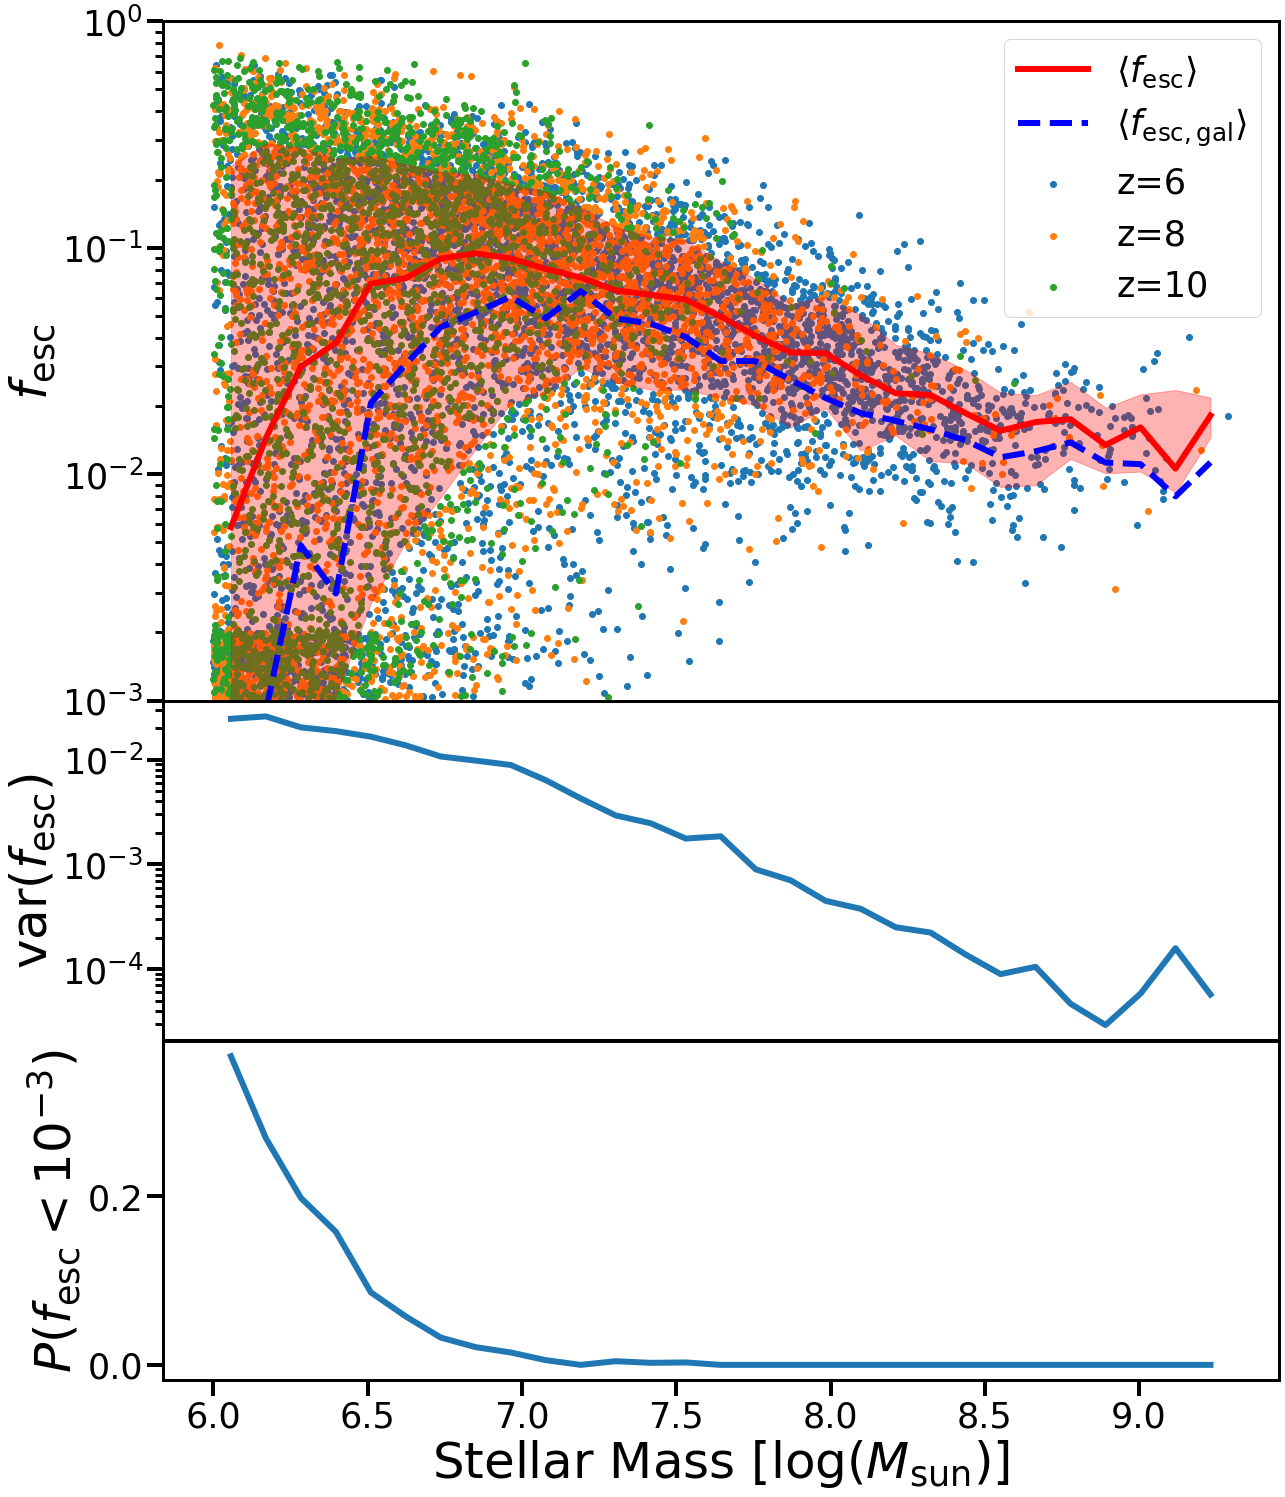

In [12]:
plot_scatter(df, halo_prop='StarMass', bins=30, include_frac=True, threshold=1e-3, save=True, lin=False, include_galaxy=True)

In [10]:
comparison = build_compare_dic()

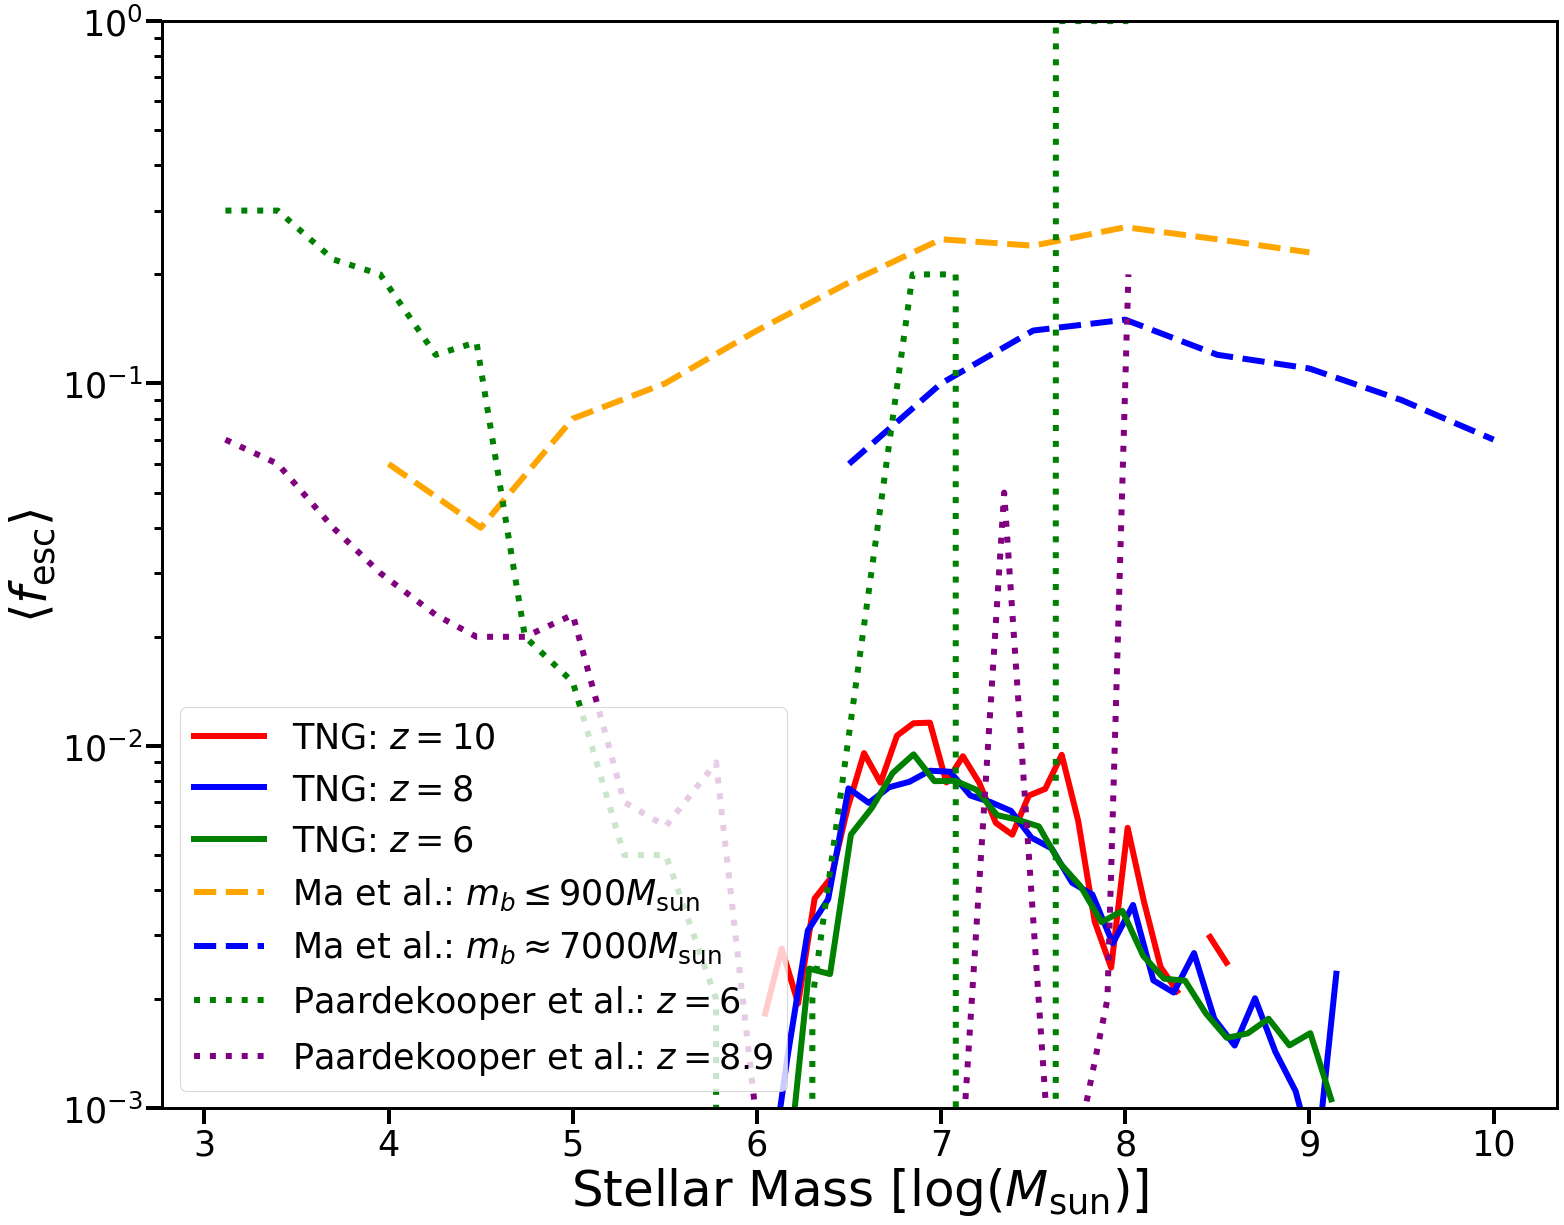

In [14]:
plot_lit_comparison(df, comparison, halo_prop='StarMass', bins=30, mode='median', save=True, lin=False)

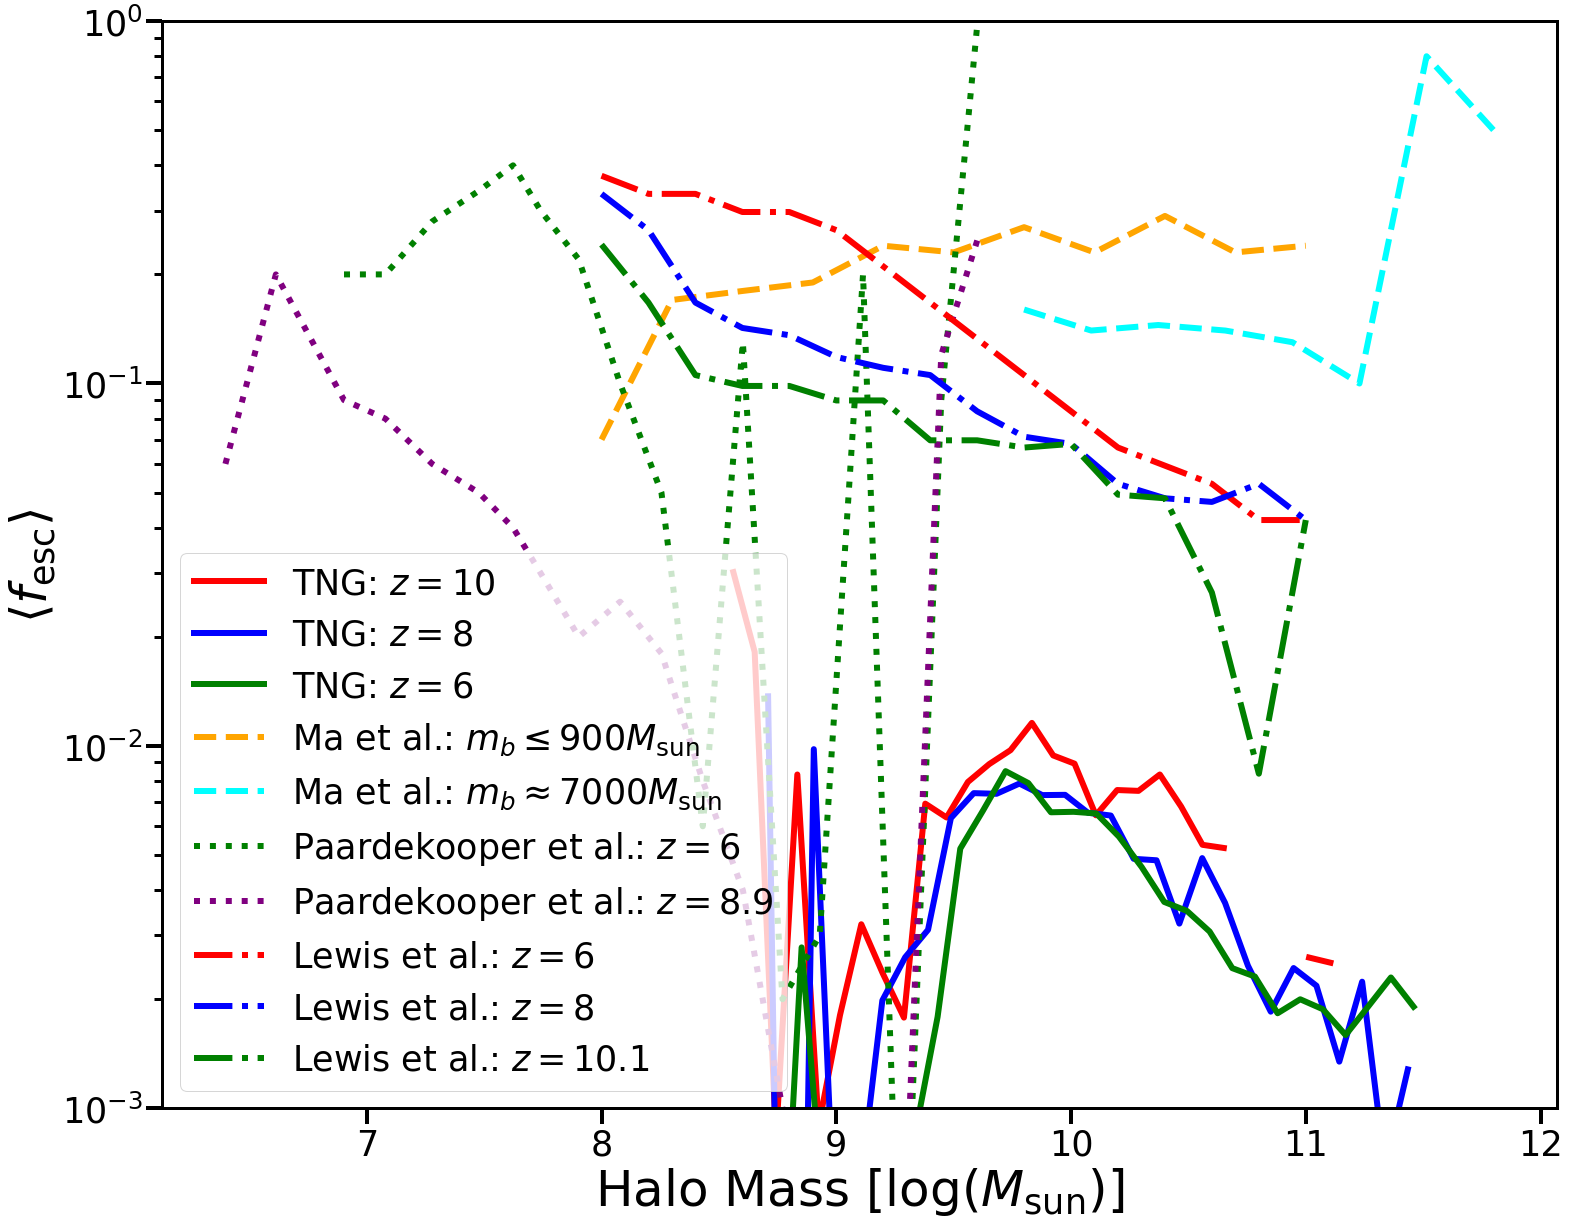

In [13]:
plot_lit_comparison(df, comparison, halo_prop='HaloMass', bins=30, mode='median', save=True, lin=False)

In [13]:
df_dust = pd.read_pickle('dfs/fid2d.pickle')
df_no_dust_full = pd.read_pickle('dfs/fid2.pickle')
update_df(df_dust)
update_df(df_no_dust)

In [40]:
df_intersection = df_no_dust_full.merge(df_dust[['ID','z','f_esc']], on=['ID', 'z'], how='inner', suffixes=('_no_dust', '_dust'))
update_df(df_intersection)

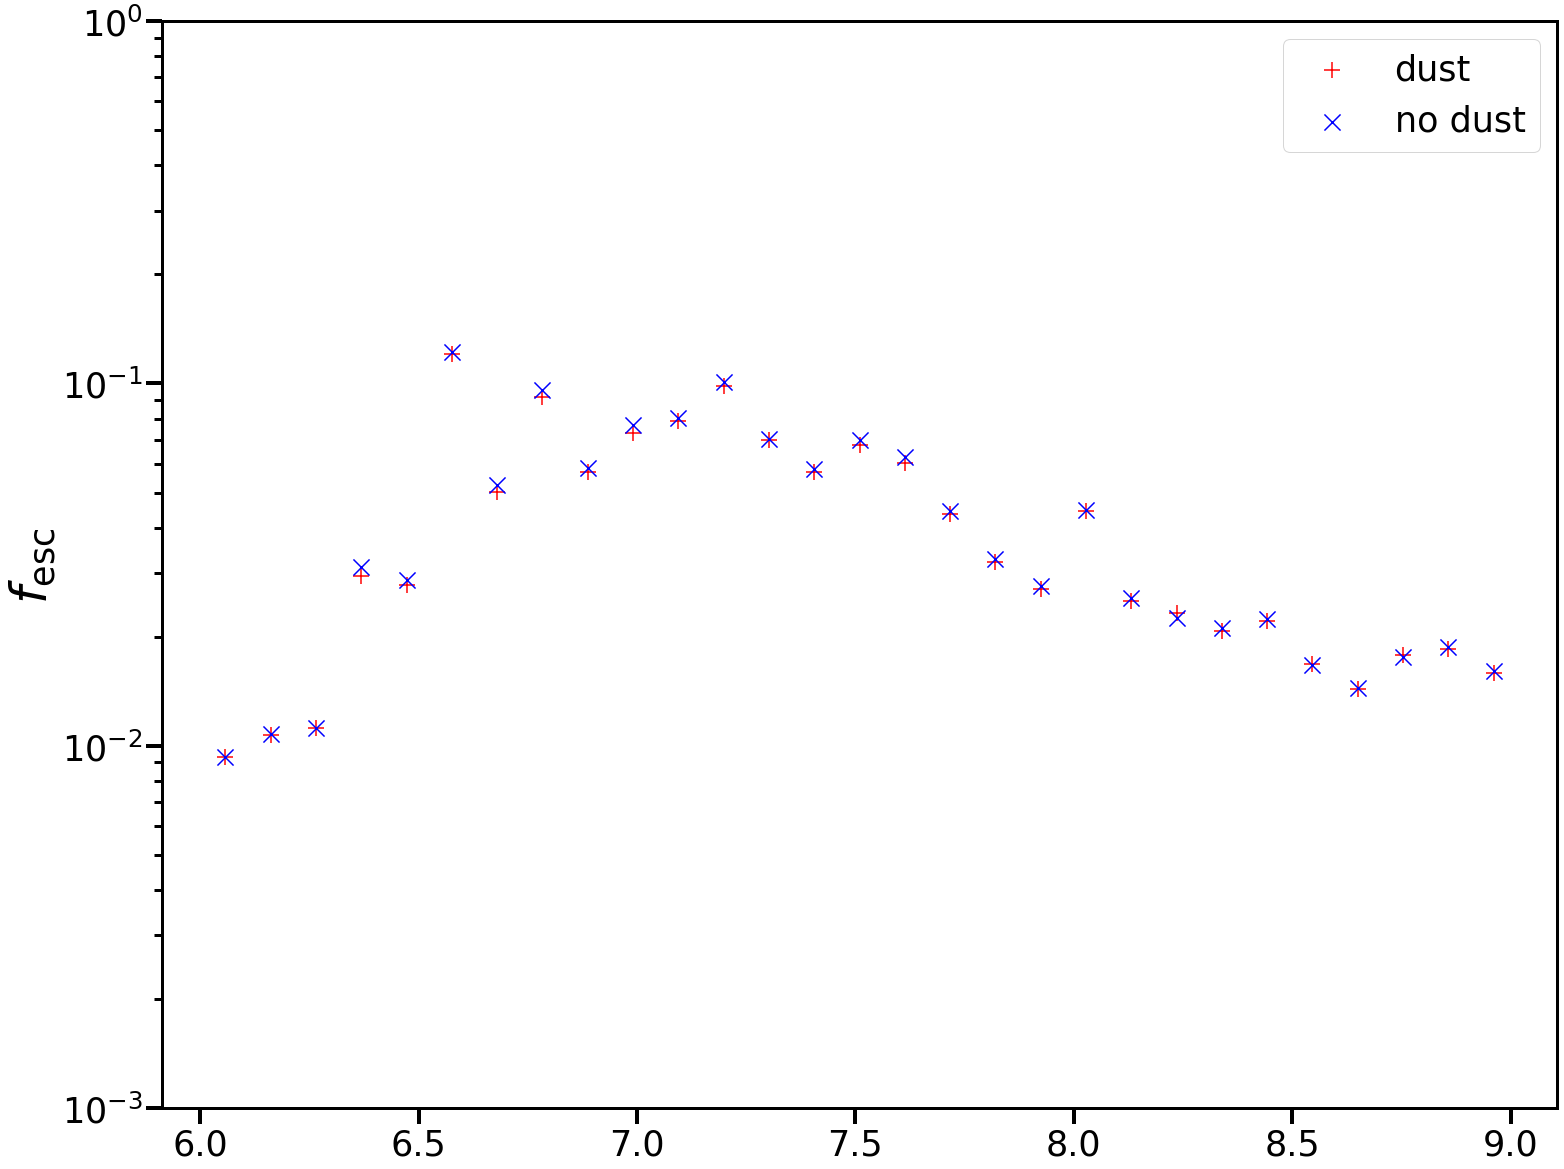

In [74]:
 plot_dust_comparison(comparison_df=df_intersection, halo_prop='StarMass', bins=30, mode='median', save=True, 
                      lin=False, galaxy=False, residual=False, with_z=False, scatter=False)

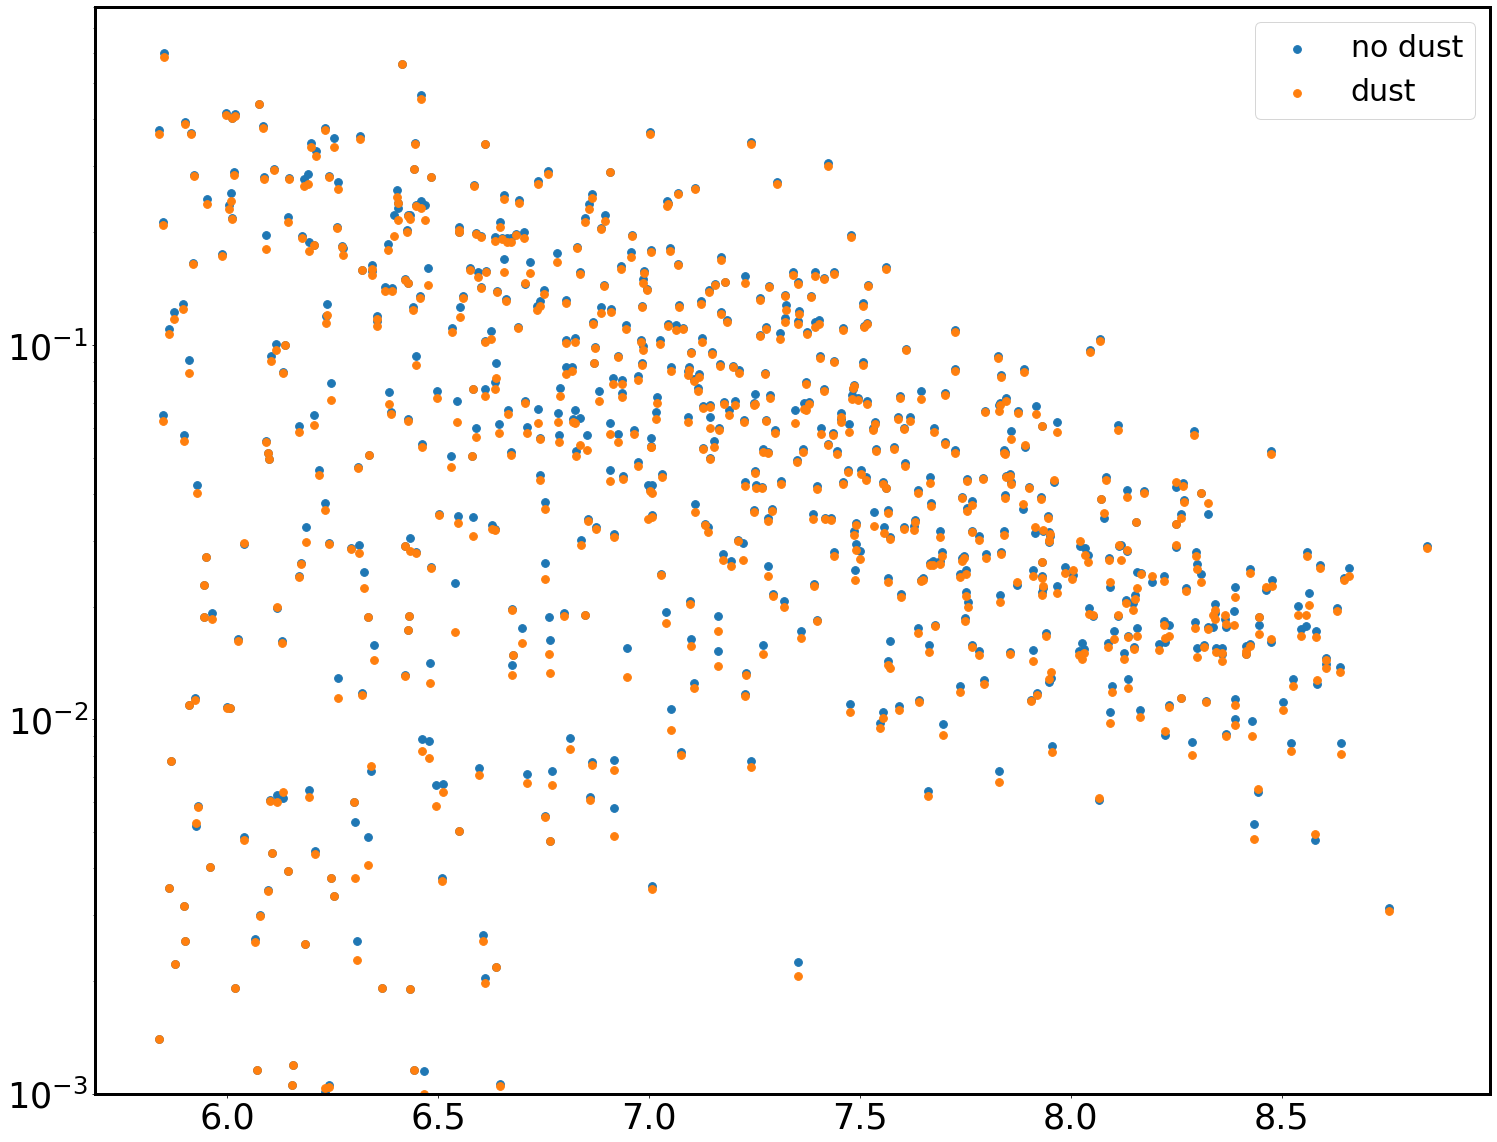

In [59]:
plt.scatter(np.log10(df_intersection.StarMass*1e10), df_intersection.f_esc_no_dust, s=60, label='no dust')
plt.scatter(np.log10(df_intersection.StarMass*1e10), df_intersection.f_esc_dust, s=60, label='dust')
plt.yscale('log')
plt.xlabel
plt.ylim(1e-3, 8e-1)
plt.legend(fontsize=30);